(a) Download [allEpochsRAT200502.tab](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/ATMUIF). Note that there is a documentation file explaining what is in these files.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn.objects as so
import statsmodels.api as sm
from seaborn import axes_style

# set notebook defaults
theme_dict = {**axes_style("whitegrid"), "grid.linestyle": ":"}
so.Plot.config.theme.update(theme_dict)

"""
dataset description
-------------------
subjectID : category
    identifies the unique subjects
coh : float
    motion coherence of the trial, between 0-1
rt : float
    response time to L/R from stimulus onset
response : int
    if response was correct (1) or error (0)
"""

cols = ["subjectID", "coh", "rt", "response"]
df = pd.read_csv("datasets/allEpochsRAT200502.csv", usecols=cols)

(b) If you condition only on 'subjectID' you'll get all the trials one rat did in its entire life. If you also condition on 'coh' (coherence), you'll get all trials with the same stimulus. The null hypothesis would be that after conditioning on both 'subjectID' and 'coh', the binomial time series (response) and the continuous-positive-valued time series (rt) should be stationary. Use whatever plots, tests, or time series analysis methods you would normally use to inspect these time series and decide they look stationary.

In [2]:
"""
stationarity tests
------------------
1: ADF and KPSS are non-stationary: the series is non-stationary
2. ADF and KPSS are stationary: the series is stationary
3. ADF is non-stationary KPSS is stationary: the series is trend stationary
4. ADF is stationary KPSS is non-stationary: the series is difference stationary
"""


def adf_test(x):
    """Augmented Dickey-Fuller unit root test.
    H0: the series has a unit root (non-stationary)
    """
    test_ = sm.tsa.stattools.adfuller(x, autolag="AIC")
    print(f"ADF statistic: {test_[0]:.3f} p-value: {test_[1]:.4f}")


def kpss_test(x):
    """Kwiatkowski-Phillips-Schmidt-Shin test for stationarity.
    H0: the process is trend stationary
    """
    import warnings

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        test_ = sm.tsa.stattools.kpss(x)
    print(f"KPSS statistic: {test_[0]:.3f} p-value: {test_[1]:.4f}")

raw timeseries
ADF statistic: -15.881 p-value: 0.0000
KPSS statistic: 11.242 p-value: 0.0100

after differencing
ADF statistic: -41.438 p-value: 0.0000
KPSS statistic: 0.012 p-value: 0.1000


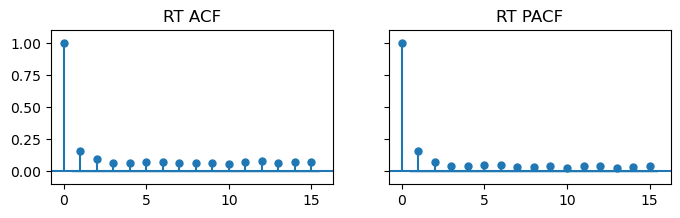

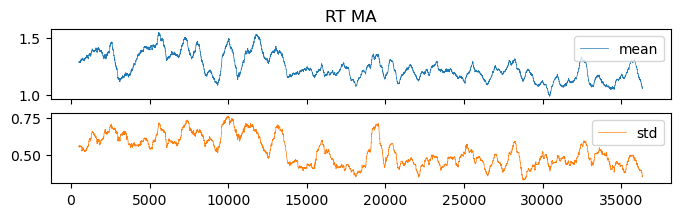

In [3]:
# 36364 trials: 29105 correct, 7259 error
df_subset = df.query("subjectID == 482 and coh == 0.65").reset_index(drop=True)

# plot the (partial) autocorrelation function
fig, axs = plt.subplots(ncols=2, figsize=(8, 2), sharey=True)
sm.graphics.tsa.plot_acf(df_subset["rt"], title="RT ACF", ax=axs[0], lags=15)
sm.graphics.tsa.plot_pacf(df_subset["rt"], title="RT PACF", ax=axs[1], lags=15)
[ax.set_ylim((-0.1, 1.1)) for ax in axs]

# plot the rolling mean and std
df_subset["rt"].rolling(window=500).agg(["mean", "std"]).plot(
    title="RT MA", subplots=True, figsize=(8, 2), linewidth=0.5
)

# stationarity tests
print("raw timeseries")
adf_test(df_subset["rt"])
kpss_test(df_subset["rt"])

print("\nafter differencing")
adf_test(df_subset["rt"].diff().dropna())
kpss_test(df_subset["rt"].diff().dropna())

raw timeseries
ADF statistic: -16.271 p-value: 0.0000
KPSS statistic: 2.311 p-value: 0.0100

after differencing
ADF statistic: -43.703 p-value: 0.0000
KPSS statistic: 0.123 p-value: 0.1000


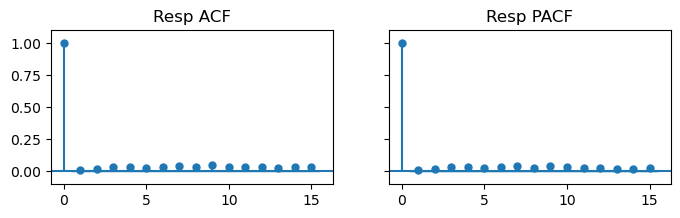

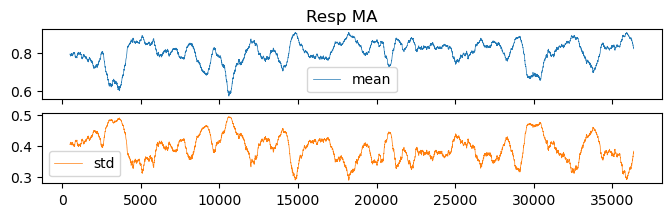

In [4]:
# plot the (partial) autocorrelation function
fig, axs = plt.subplots(ncols=2, figsize=(8, 2), sharey=True)
sm.graphics.tsa.plot_acf(df_subset["response"], title="Resp ACF", ax=axs[0], lags=15)
sm.graphics.tsa.plot_pacf(df_subset["response"], title="Resp PACF", ax=axs[1], lags=15)
[ax.set_ylim((-0.1, 1.1)) for ax in axs]

# plot the rolling mean and std
df_subset["response"].rolling(window=500).agg(["mean", "std"]).plot(
    title="Resp MA", subplots=True, figsize=(8, 2), linewidth=0.5
)

# stationarity tests
print("raw timeseries")
adf_test(df_subset["response"])
kpss_test(df_subset["response"])

print("\nafter differencing")
adf_test(df_subset["response"].diff().dropna())
kpss_test(df_subset["response"].diff().dropna())

(c) Selecting data from one subject as an example, inspect how average accuracy and mean RT depend on 'coh' (pooling trials over all time), and then make some plots like Shevinsky Fig 2A-C to check if accuracy depends on RT within any given coherence, pooling over all time.

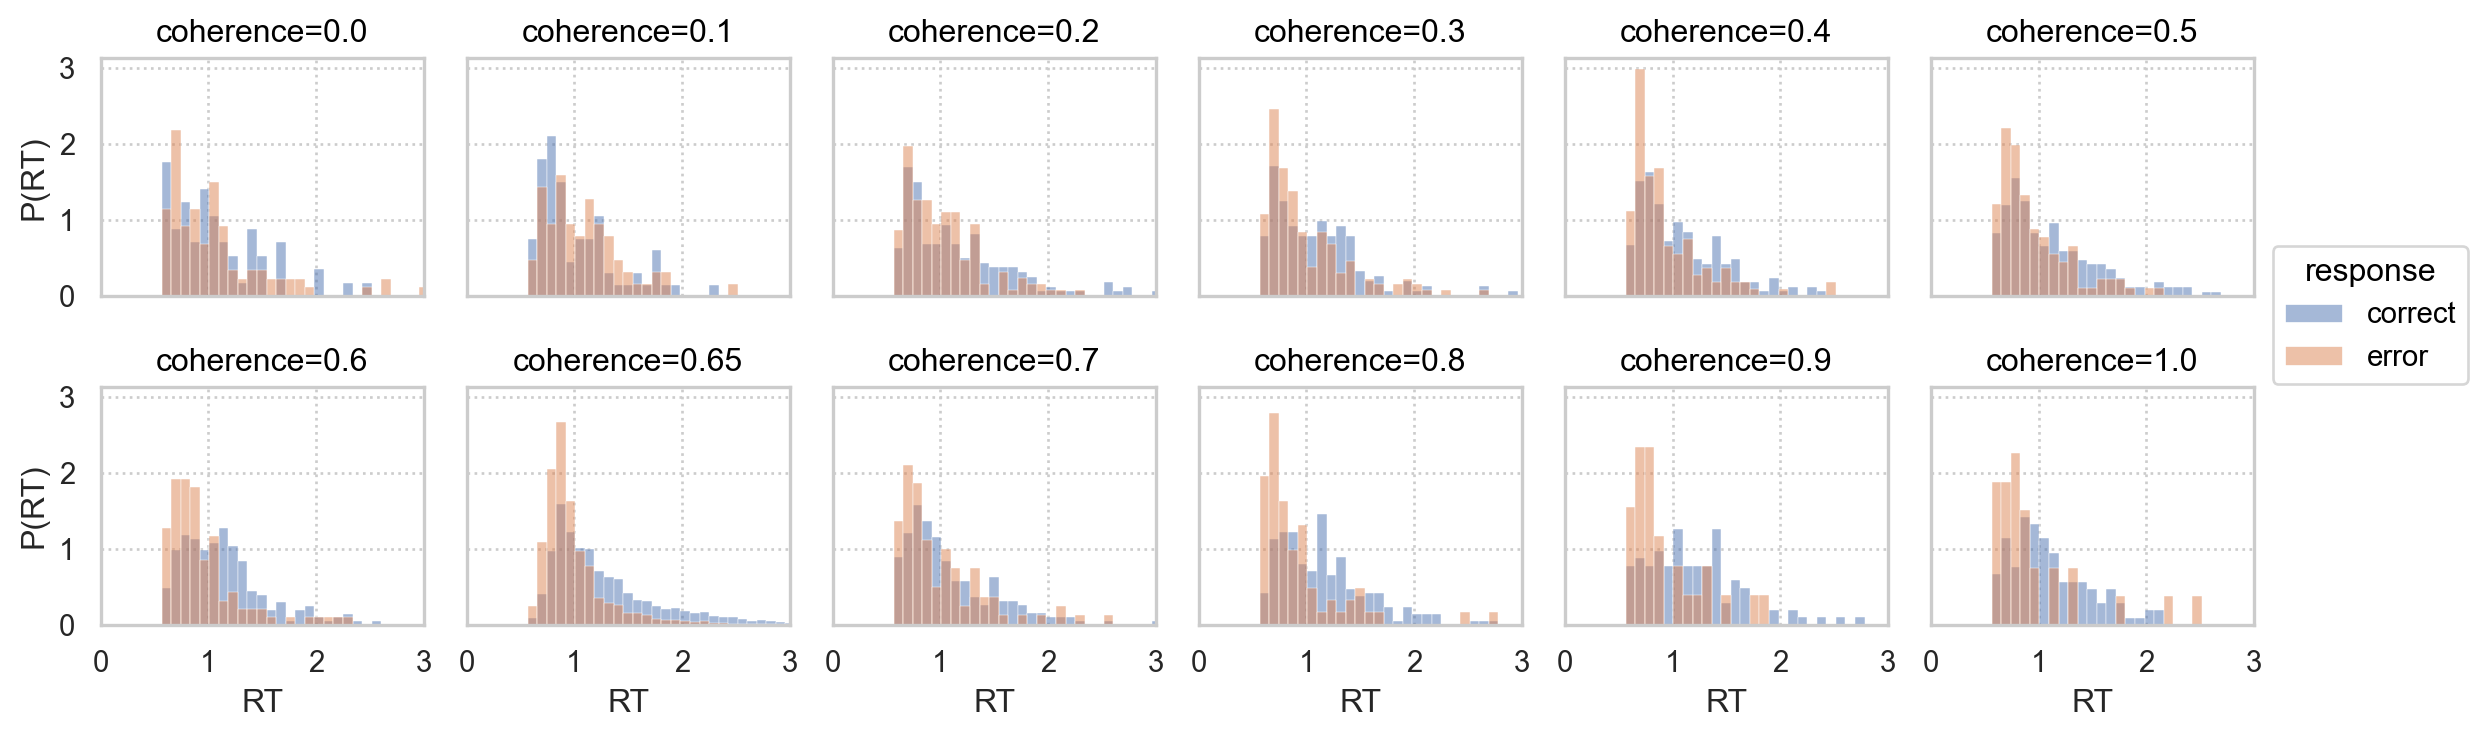

In [5]:
df_subset = df.query("subjectID == 482")

# plot distribution of RTs
(
    so.Plot(df_subset, x="rt", color=df_subset["response"].map({1: "correct", 0: "error"}))
    .facet(col="coh", wrap=6)
    .add(so.Bars(alpha=0.5), so.Hist(stat="density", bins=50))
    .limit(x=(0, 3))
    .layout(size=(12, 4))
    .label(x="RT", y="P(RT)", title="coherence={}".format)
)

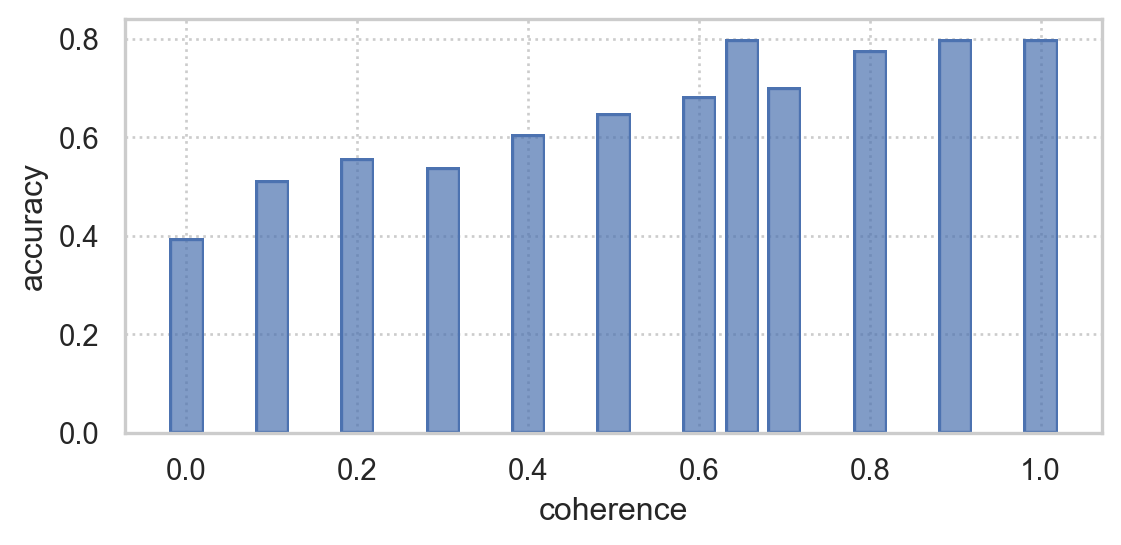

In [6]:
# plot coherence vs accuracy
(
    so.Plot(df_subset, x="coh", y="response")
    .add(so.Bar(), so.Agg(func="mean"))
    .label(x="coherence", y="accuracy")
    .layout(size=(6, 3))
)

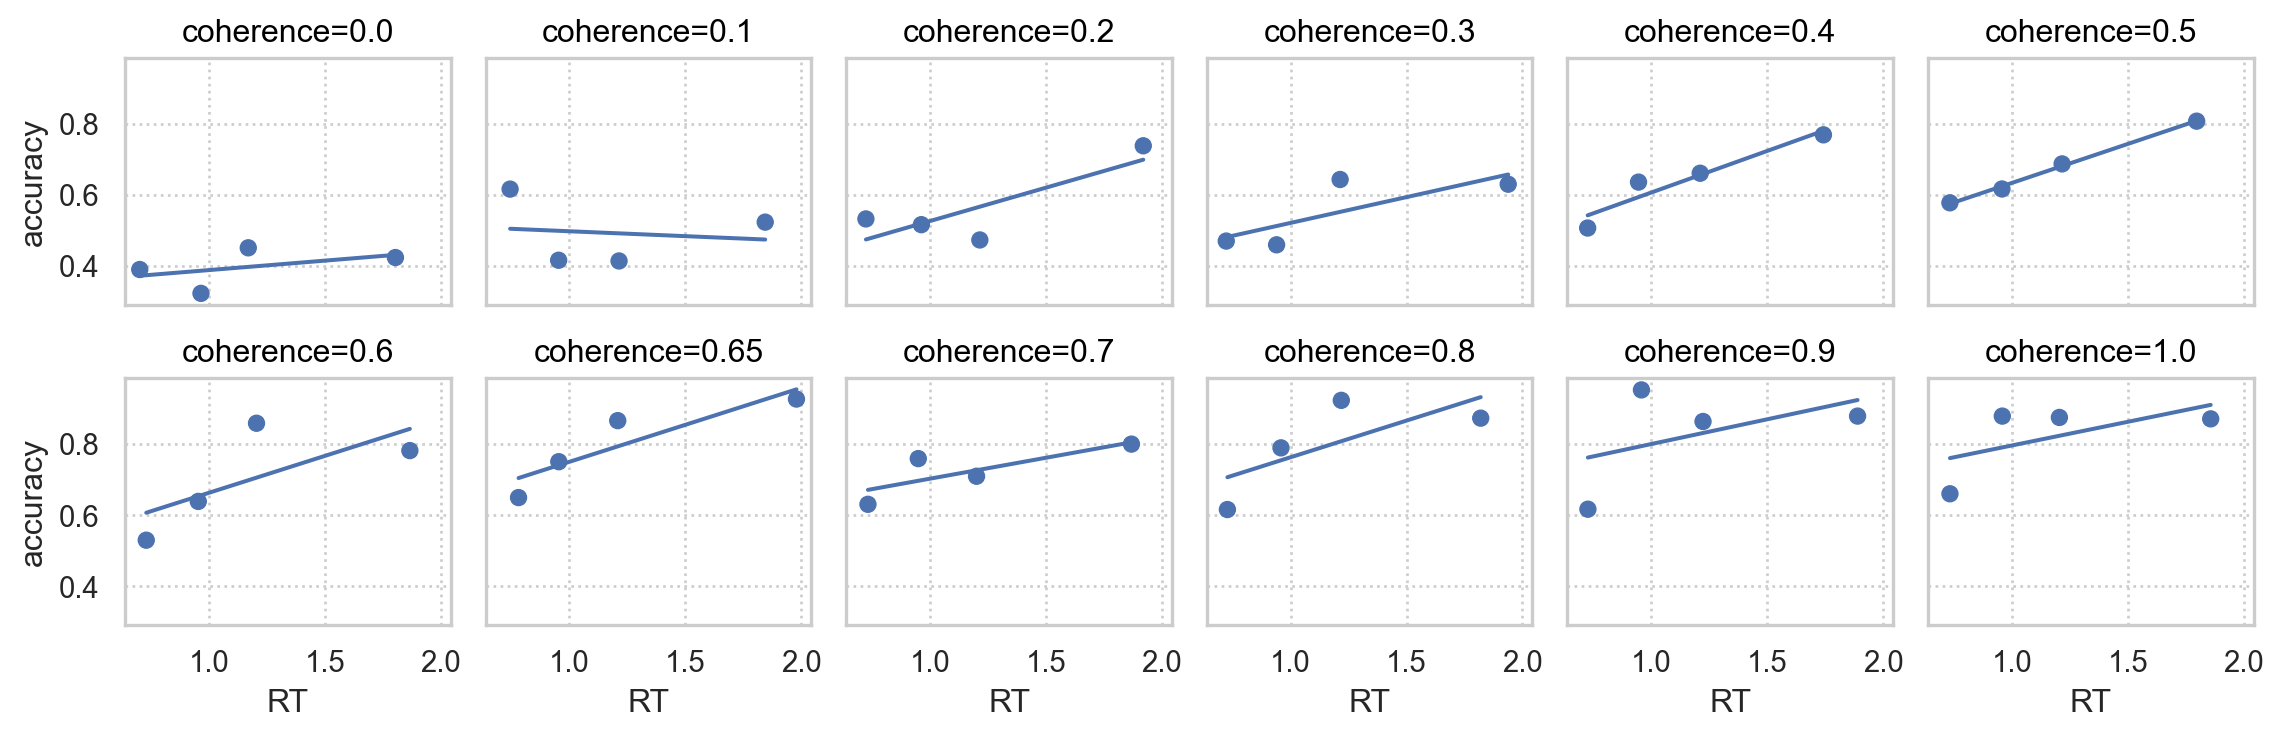

In [7]:
# plot RT vs accuracy
df_quartile = (
    df_subset.assign(rt_quartile=pd.qcut(df_subset["rt"], 4, labels=False))
    .groupby(["coh", "rt_quartile"], as_index=False)[["rt", "response"]]
    .agg("mean")
)

(
    so.Plot(df_quartile, x="rt", y="response")
    .facet(col="coh", wrap=6)
    .add(so.Dot())
    .add(so.Line(), so.PolyFit(order=1))
    .layout(size=(12, 4))
    .label(x="RT", y="accuracy", title="coherence={}".format)
)